In [2]:
import csv
import datetime
import itertools

import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import pathlib
import shutil

In [3]:
path = '/home/xandao/Documentos/resultados_gimp/identificacao_george/especie/acima-20/RGB'

In [4]:
list_files = [file for file in pathlib.Path(path).rglob('mean.csv') if file.is_file()]
len(list_files)

130

In [5]:
list_extractor = {
    'lbp': [59],
    'surf64': [128, 256, 257],
    'surf128': [128, 256, 513],
    'mobilenetv2': [128, 256, 512, 1024, 1280],
    'resnet50v2': [128, 256, 512, 1024, 2048],
    'vgg16': [128, 256, 512]
}
index = [e + '_' + str(d) + '_' + m for e in list_extractor.keys() for d in reversed(list_extractor[e]) for m in ['mean', 'std']]

In [6]:
list_classifier = ['DecisionTreeClassifier', 'KNeighborsClassifier', 'MLPClassifier', 'RandomForestClassifier', 'SVC']
list_dim = [256, 400, 512]
# list_segmented = ['manual', 'unet']
list_segmented = ['unet']
columns = [c + '_' + str(d) + '_' + s for c in list_classifier for s in sorted(list_segmented) for d in list_dim]

In [7]:
def create_sheet():
    return {
        'mean': pd.DataFrame(index=index, columns=columns),
        'time': pd.DataFrame(index=index, columns=columns),
        'folder': pd.DataFrame(index=index, columns=columns)
    }

sheet_rgb = create_sheet()
sheet_grayscale = create_sheet()
display(sheet_rgb['mean'])

,DecisionTreeClassifier_256_unet,DecisionTreeClassifier_400_unet,DecisionTreeClassifier_512_unet,KNeighborsClassifier_256_unet,KNeighborsClassifier_400_unet,KNeighborsClassifier_512_unet,MLPClassifier_256_unet,MLPClassifier_400_unet,MLPClassifier_512_unet,RandomForestClassifier_256_unet,RandomForestClassifier_400_unet,RandomForestClassifier_512_unet,SVC_256_unet,SVC_400_unet,SVC_512_unet
lbp_59_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lbp_59_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_257_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_257_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_256_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_256_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_128_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_128_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf128_513_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf128_513_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
ROUND_VALUE = 3

def round_mean(value):
     return '=ROUND(' + str(value) + ' * 100; ' + str(ROUND_VALUE) + ')'


def round_time(value):
     return '=ROUND(' + str(value) + '; ' + str(ROUND_VALUE) + ')'


def plus_minus_std(value, top_k, total_top_k):
     return '=CONCATENATE("±"; ROUND(' + str(value) + ' * 100; ' + str(ROUND_VALUE) + '); " (' + str(top_k) + '/' + total_top_k + ')")'


def get_classifier(path):
    classifier = list(filter(lambda x: x.lower() in str(path).lower(), list_classifier))

    if len(classifier) == 0:
        raise ValueError('classifier not available in list')

    return classifier[0]


def is_date(string):
    try:
        date = datetime.datetime.strptime(string, '%d-%m-%Y-%H-%M-%S')
        return True

    except ValueError:
        return False


def get_date(path):
    for p in str(path).split('/'):
        if is_date(p):
            return p
    return None


def set_values_sheet(column, date, index_folder, index_mean, index_std, mean, mean_time_search_best_params, mean_time_train_valid, sheet, std, top_k, total_top_k):
    sheet['mean'].loc[index_mean, column] = round_mean(mean)
    sheet['mean'].loc[index_std, column] = plus_minus_std(std, top_k, total_top_k)
    sheet['time'].loc[index_mean, column] = round_time(mean_time_train_valid)
    sheet['time'].loc[index_std, column] = round_time(mean_time_search_best_params)
    sheet['folder'].loc[index_folder, column] = date

plot = []
def fill_sheet_mean_std(classifier, color_mode, date, filename, image_size, extractor, n_features, n_patch, segmented):
    sheet_mean = pd.read_csv(filename, sep=';', index_col=0, header=None)
    mean = sheet_mean.loc['mean_f1_sum'][1]
    mean_time_search_best_params = sheet_mean.loc['mean_time_search_best_params'][1]
    mean_time_train_valid = sheet_mean.loc['mean_time_train_valid'][1]
    std = sheet_mean.loc['std_f1_sum'][1]

    sheet_mean_top_k_sum = pd.read_csv(str(filename).replace('mean.csv', 'mean_top_k/mean_top_k_sum.csv'), sep=';', index_col=0, header=0)
    sheet_info_top_k_sum = pd.read_csv(str(filename).replace('mean.csv', '0/top_k/sum/info_top_k_sum.csv'), sep=';', index_col=0, header=None)
    top_k = sheet_mean_top_k_sum.iloc[1]['top_k']
    total_top_k = sheet_info_top_k_sum.loc['total'][1]

    index_mean = extractor + '_' + n_features + '_' + 'mean'
    index_std = extractor + '_' + n_features + '_' + 'std'
    column = classifier + '_' + image_size + '_' + segmented

    plot.append({
        'extractor': extractor,
        'n_features': n_features,
        'classifier': classifier,
        'image_size': image_size,
        'mean': mean
    })

    if color_mode == 'grayscale':
        set_values_sheet(column, date, index_mean, index_mean, index_std, mean, mean_time_search_best_params, mean_time_train_valid, sheet_grayscale, std, top_k, total_top_k)
    else:
        set_values_sheet(column, date, index_mean, index_mean, index_std, mean, mean_time_search_best_params, mean_time_train_valid, sheet_rgb, std, top_k, total_top_k)

In [9]:
for file in sorted(list_files):
    sheet_info = pd.read_csv(str(file).replace('mean.csv', 'info.csv'), header=None, sep=';', index_col=0)

    classifier = get_classifier(file)
    color_mode = sheet_info.loc['color_mode'][1]
    image_size = sheet_info.loc['dim_image'][1]
    extractor = sheet_info.loc['extractor'][1]
    n_features = sheet_info.loc['data_n_features'][1]
    n_patch = sheet_info.loc['n_patch'][1]
    slice_patch = sheet_info.loc['slice'][1]
    segmented = 'unet' if 'unet' in str(file).lower() or 'u-net' in str(file).lower() else 'manual'
    date = get_date(file)

    fill_sheet_mean_std(classifier, color_mode, date, file, image_size, extractor, n_features, n_patch, segmented)

In [10]:
if os.path.exists('out/planilha'):
    shutil.rmtree('out/planilha')
pathlib.Path('out/planilha').mkdir(exist_ok=True, parents=True)
sheet_grayscale['mean'].to_csv('out/planilha/grayscale.csv', sep=';', na_rep='', quoting=csv.QUOTE_ALL)
sheet_grayscale['mean'].to_excel('out/planilha/grayscale.xlsx', na_rep='', engine='xlsxwriter')
sheet_rgb['mean'].to_csv('out/planilha/rgb.csv', mode='w', sep=';', na_rep='', quoting=csv.QUOTE_ALL)
sheet_rgb['mean'].to_excel('out/planilha/rgb.xlsx', na_rep='', engine='xlsxwriter')
sheet_rgb['time'].to_csv('out/planilha/rgb_t.csv', mode='w', sep=';', na_rep='', quoting=csv.QUOTE_ALL)
sheet_rgb['time'].to_excel('out/planilha/rgb_t.xlsx', na_rep='', engine='xlsxwriter')

In [11]:
display(sheet_rgb['mean'])

,DecisionTreeClassifier_256_unet,DecisionTreeClassifier_400_unet,DecisionTreeClassifier_512_unet,KNeighborsClassifier_256_unet,KNeighborsClassifier_400_unet,KNeighborsClassifier_512_unet,MLPClassifier_256_unet,MLPClassifier_400_unet,MLPClassifier_512_unet,RandomForestClassifier_256_unet,RandomForestClassifier_400_unet,RandomForestClassifier_512_unet,SVC_256_unet,SVC_400_unet,SVC_512_unet
lbp_59_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lbp_59_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_257_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_257_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_256_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_256_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_128_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf64_128_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf128_513_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf128_513_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


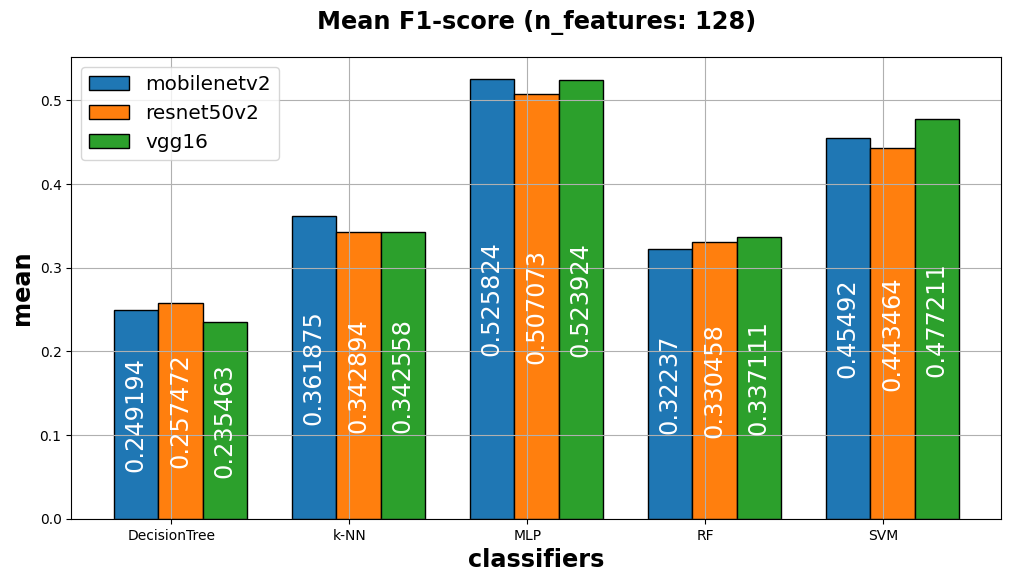

In [33]:
# plt.show()
image_size = '256'
n_features = '128'
bar_width = 0.25

def get_list_mean(extractor):
    return [float(p['mean']) for p in plot if extractor in p['extractor'] and image_size in p['image_size'] and n_features == p['n_features']]

def add_bar_label(axis):
    for container in axis.containers:
        axis.bar_label(container, label_type='center', rotation=90, color='white', fontsize='xx-large')

mean_mobilenet = get_list_mean('mobilenetv2')
mean_vgg = get_list_mean('vgg')
mean_resnet = get_list_mean('resnet')

labels_axis_x = ['DecisionTree', 'k-NN', 'MLP', 'RF','SVM']
X_axis = np.arange(len(labels_axis_x))

fig1, ax = plt.subplots(figsize=(12, 6))

ax.bar(X_axis, mean_mobilenet, width=bar_width, edgecolor = 'black', label='mobilenetv2')
ax.bar(X_axis+0.25, mean_resnet, width=bar_width, edgecolor = 'black', label='resnet50v2')
ax.bar(X_axis+0.5, mean_vgg, width=bar_width, edgecolor = 'black', label='vgg16')

add_bar_label(ax)

r = np.arange(len(labels_axis_x))
plt.xticks(r + 0.4/2, labels_axis_x)
plt.title('Mean F1-score (n_features: 128)', fontweight ='bold', fontsize = 'xx-large', pad=20)
plt.xlabel('classifiers', fontweight ='bold', fontsize = 'xx-large')
plt.ylabel('mean', fontweight ='bold', fontsize = 'xx-large')
plt.legend(fontsize='x-large')
plt.savefig(f'out/planilha/f1_n_features_{n_features}_{extractor}.png', dpi=300)
plt.grid()
plt.show()